# Regression: Predicting fuel efficiency

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

In [265]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [266]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [267]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

#tf version should be 2.5 or higher
print("tensorflow version: " + tf.__version__)

# check if GPU is being used
print("GPU Status: ", end = '')
if len(tf.config.list_physical_devices('GPU')) != 0: print("Active")
else: print("Inactive")

tensorflow version: 2.10.0
GPU Status: Active


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).



### Get the data
First download the dataset.

In [268]:
import os

#  - NOTE - 
# Getting data from local directory. 
# Remote dataset collection not working. 

local_dataset_path = "file:" + os.getcwd() + "\\auto-mpg.data"
dataset_path = keras.utils.get_file("auto-mpg.data", origin = local_dataset_path)

Import it using pandas

In [269]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values.

In [270]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

One simple option is to drop those rows.

In [271]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [272]:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [273]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='', dtype = int)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into train and test

Now split the dataset into a training set and a test set.

In [274]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

c:\Users\ptpsm\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ptpsm\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ptpsm\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ptpsm\anaconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

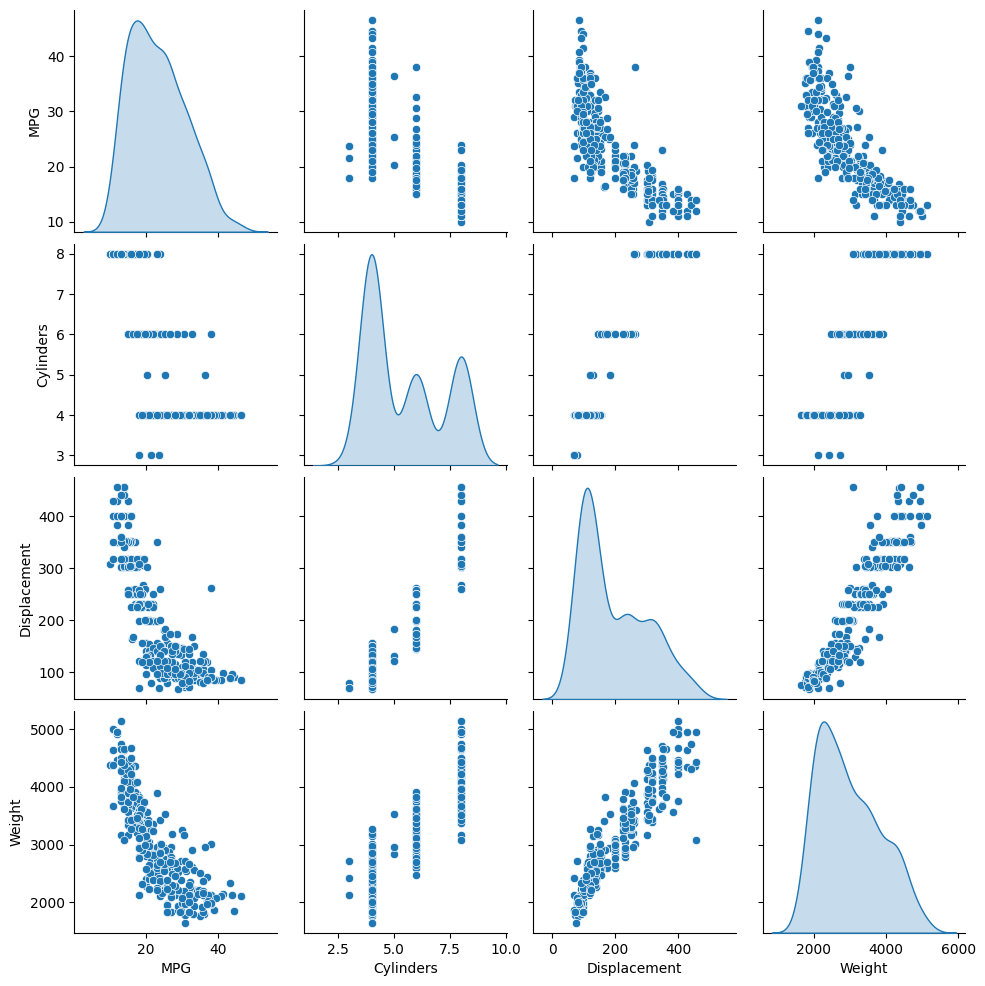

In [275]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Also look at the overall statistics:

In [276]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [277]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [278]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

In [279]:
import math

#  - NOTE - 
# Hidden Layers: 1
# Dropout: 15% 
# Early Stopping Patience: 5 Epochs
# Learning Rate Decay: 0.0125 * 0.6^epoch
# Batch Normaliztion

def build_model():
    model = tf.keras.Sequential([
        layers.Dense(512, input_shape = [len(train_dataset.keys())]),
        layers.BatchNormalization(center = True, scale = False),
        layers.Activation('relu'),

        layers.Dropout(0.15),

        layers.Dense(256),
        layers.BatchNormalization(center = True, scale = False),
        layers.Activation('relu'),

        layers.Dropout(0.15),
        
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer = optimizer,
                metrics=['mae', 'mse'])
                
    return model

def lr_decay(epoch):
    return 0.0125 * math.pow(0.6, epoch)

In [280]:
# Build & Compile Model
model = build_model()

# Learning Rate Decay
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose = True)

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

In [281]:
# Test Batch
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 43ms/step


array([[ 0.07946122],
       [ 0.0172155 ],
       [-0.0549142 ],
       [-0.00185245],
       [ 0.1314202 ],
       [-0.02645839],
       [ 0.15226139],
       [ 0.20474344],
       [ 0.09960644],
       [ 0.33474383]], dtype=float32)

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [282]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, lr_decay_callback, tfdocs.modeling.EpochDots()])


Epoch 1: LearningRateScheduler setting learning rate to 0.0125.

Epoch: 0, loss:211.1604,  lr:0.0125,  mae:12.6488,  mse:211.1604,  val_loss:55.9823,  val_mae:5.9165,  val_mse:55.9823,  
.
Epoch 2: LearningRateScheduler setting learning rate to 0.0075.
.
Epoch 3: LearningRateScheduler setting learning rate to 0.0045.
.
Epoch 4: LearningRateScheduler setting learning rate to 0.0026999999999999997.
.
Epoch 5: LearningRateScheduler setting learning rate to 0.00162.
.
Epoch 6: LearningRateScheduler setting learning rate to 0.0009719999999999998.
.
Epoch 7: LearningRateScheduler setting learning rate to 0.0005831999999999999.
.
Epoch 8: LearningRateScheduler setting learning rate to 0.00034991999999999993.
.
Epoch 9: LearningRateScheduler setting learning rate to 0.00020995199999999993.
.
Epoch 10: LearningRateScheduler setting learning rate to 0.00012597119999999996.
.
Epoch 11: LearningRateScheduler setting learning rate to 7.558271999999998e-05.
.
Epoch 12: LearningRateScheduler setting

Visualize the model's training progress using the stats stored in the `history` object.

In [283]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,lr,epoch
78,9.870152,2.333054,9.870152,7.334643,2.060750,7.334643,6.204511e-20,78
79,11.901484,2.573378,11.901484,7.327520,2.059800,7.327520,3.722706e-20,79
80,10.965289,2.355925,10.965289,7.328209,2.059242,7.328209,2.233624e-20,80
81,14.619501,2.902659,14.619501,7.326621,2.057564,7.326621,1.340174e-20,81
82,10.156762,2.428355,10.156762,7.333598,2.057887,7.333598,8.041046e-21,82


In [284]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'Mean Abs Error [MPG]')

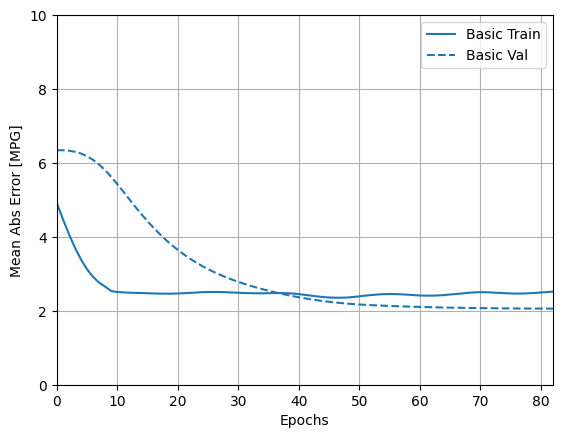

In [285]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('Mean Abs Error [MPG]')

Text(0, 0.5, 'Mean Square Error [MPG^2]')

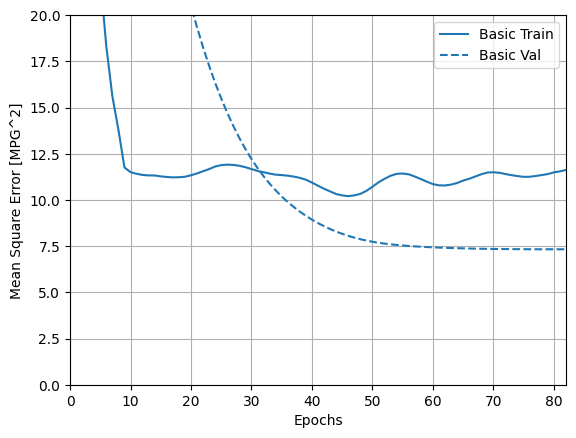

In [286]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('Mean Square Error [MPG^2]')

Now determine how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [287]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.1679 - mae: 1.7376 - mse: 5.1679 - 23ms/epoch - 8ms/step
Testing set Mean Abs Error:  1.74 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


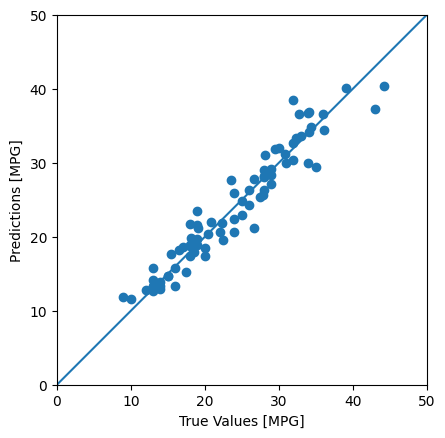

In [288]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
